<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_1a_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank"><< OSI SAF sea ice introductory</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./2_2_OSI_SAF_sea_ice_plot_anomaly_as_a_spiral.ipynb" target="_blank">Plot OSI SAF sea ice data as a spiral >> </a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Thomas Lavergne (Meteorologisk institutt/OSI SAF), Gwenaël Le Bras (Météo-France/OSI SAF)

<i>This notebook is adapted from a notebook available on T.Lavergne <a href="https://github.com/TomLav/snippets/blob/main/Monthly%20Sea%20Ice%20Concentration%20Anomalies.ipynb">git repository </a>.</i>

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?labpath=2_OSI_SAF_sea_ice_use_case%2F2_1_OSI_SAF_sea_ice_Monthly_concentration_anomalies.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Use case</h3></div>


<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
There are no prerequisite notebooks for this module.
</div>
<hr>

# 2.1 Use case : Compute monthly mean sea-ice concentration anomaly from EUMETSAT OSI SAF data
### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Global Sea Ice Concentration climate data record (SMMR/SSMI/SSMIS), release 3 | EO:EUM:DAT:1021  | <a href="https://osi-saf.eumetsat.int/products/osi-450-a1" target="_blank">link</a> | OSI-450-a1 | 
| Global Sea Ice Concentration interim climate data record, release 3 | EO:EUM:DAT:0645 | <a href="https://osi-saf.eumetsat.int/products/osi-430-a" target="_blank">link</a> | OSI-430-a 

### Learning outcomes

At the end of this notebook you will know;
* How to access Sea Ice Concentration (SIC) data from Thredds
* How to plot a SIC map
* How to compute and plot a SIC anomaly map
* How to compute and plot a monthly mean SIC anomaly map

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Creating the workspace](#section1)
 1. [Read the data from Thredds](#section2) 
 1. [Compute and plot the anomaly](#section3)
 1. [Plot the monthly mean SIC and the outline of the climatology median edge.](#section4)
 1. [Save the computed data into a netCDF.](#section5)
 


<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Creating the workspace
[Back to top](#TOC-TOP)

</div>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [9]:
import os
import xarray as xr
from datetime import date
import json
from copy import copy
import numpy as np

Next we will create a directory to store the files we will create in this notebook.

In [11]:
download_dir = os.path.join(os.getcwd(), "anomalies")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Read the data from Thredds
[Back to top](#TOC-TOP)

</div>

We will begin by defining the area we want to work on and specifying the date of the anomaly we are interested in. <br><br>
The available data cover a time period from 25/10/1978 up to two days before present date. Data up to 31/12/2020 we are going to use are from the Climate Data Record (<a href="https://osi-saf.eumetsat.int/products/osi-450-a1">OSI-450-a1</a>), while for the more recent one, we will use the Interim Climate Data Record (<a href="https://osi-saf.eumetsat.int/products/osi-430-a">OSI-430-a</a>), which are released with a two-day latency. As for the area, it can be either "nh" for Northern Hemisphere, or "sh" for the Southern Hemisphere. <br><br>
In this Use Case, we are focusing on the extremely <a href="https://osi-saf.eumetsat.int/community/stories/antarctic-sea-ice-through-low-extent-period">low sea ice maximum in Antarctica</a>, which was measured in our data on 12th September 2023.

In [13]:
dt = date(2023,9,12)
area = 'sh'
outdir = '.'
indirs = None

# climo : years to include in the climatology run. **Both ends are included**.
climo = (1981, 2010)

We then set to interrogate OSI SAF Thredds server at the <a href="https://www.met.no/en" target="_blank">Norwegian Meteorological Institute</a>.

In [15]:
# input monthly SIC files
fn_patt = 'ice_conc_{a:}_ease2-250_{c:}_{d:%Y%m}.nc'
fn_patt_src = {'cdr': 'cdr-v3p1', 'icdr': 'icdr-v3p0', 'icdrft': 'icdrft-v3p0'}

if indirs is None:
    inpdir_cdr = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a1_files/monthly/'
    inpdir_icdr = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/monthly/'
    # access through THREDDS/OpenDAP
    sources = {'cdr':inpdir_cdr,
              'icdr':inpdir_icdr,
              'icdrft':inpdir_icdr}
    jsond = json.dumps(sources, sort_keys=True, indent=4)
else:
    # load json file with path to input directories (if the daily SIC files are downloaded to a local disk)
    # an example json file (prepare_monthly_osisaf_sic_opendap.json) is provided to demonstrate the format
    #   expected for the json file (but the effect will be the same as setting indirs to None: read from
    #   THREDDS/opendap)
    with open(indirs, 'r') as f:
        sources = json.load(f)

We then interrogate the Thredds server to select the relevent data.

In [17]:
def find_one_monthly_sic_file(dt, area):
    
    found_one_file = False
    for cdr in ('cdr', 'icdr', 'icdrft'):
        fn = fn_patt.format(a=area, d=dt, c=fn_patt_src[cdr])
        fn = os.path.join(sources[cdr],'{:%Y/}'.format(dt),fn)
        try:
            # this url exists, append it and move to next date
            ds = xr.open_dataset(fn)
            found_one_file = True
            return fn, cdr
        except OSError:
            # no valid file at this url, check the next rule
            # print("Failed with pattern {}".format(fn))
            pass
        
    # no file found. Add a warning (but we can continue)
    if not found_one_file:
        print("WARNING: could not find OSI SAF SIC v3 file for {} {}".format(area, dt))
        return None, None

def find_climo_monthly_sic_file(year_start, year_end, area, month):
    
    files = []
    for year in range(year_start, year_end+1):
        dt = date(year, month, 15)
        fn, src = find_one_monthly_sic_file(dt, area)
        if fn:
            files.append(fn)
    
    return files

fn, src = find_one_monthly_sic_file(dt, area)
climo_fns = find_climo_monthly_sic_file(climo[0], climo[1], area, dt.month)

if fn is None:
    raise ValueError("Found no file for target month.")

if len(climo_fns) == 0:
    raise ValueError("Found no files for climatology month.")

print(fn)
print(climo_fns)

https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/monthly/2023/ice_conc_sh_ease2-250_icdr-v3p0_202309.nc
['https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a1_files/monthly/1981/ice_conc_sh_ease2-250_cdr-v3p1_198109.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a1_files/monthly/1982/ice_conc_sh_ease2-250_cdr-v3p1_198209.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a1_files/monthly/1983/ice_conc_sh_ease2-250_cdr-v3p1_198309.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a1_files/monthly/1984/ice_conc_sh_ease2-250_cdr-v3p1_198409.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a1_files/monthly/1985/ice_conc_sh_ease2-250_cdr-v3p1_198509.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a1_files/monthly/1986/ice_conc_sh_ease2-250_cdr-v3p1_198609.nc', 'https://thredds

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Compute and plot the anomaly
[Back to top](#TOC-TOP)

</div>

We start by computing the monthly mean sea ice concentration (SIC) of the selected date. <br><br>
The first step is to reconstruct the unfiltered, unthresholded sea ice concentration using the raw sea ice concentration values. This procedure is for expert sea ice data users. For more detailed information, please consult the <a href="https://osisaf-hl.met.no/sites/osisaf-hl/files/user_manuals/osisaf_cdop3_ss2_pum_sea-ice-conc-climate-data-record_v3p1.pdf">product user manual</a> (section 5.1.2).

In [19]:
# A routine to reconstruct the unfiltered, unthresholded SICs from a OSI SAF SIC CDR file
def reconstruct_sic(ds):
    ice_conc = ds['ice_conc'].to_masked_array()
    raw_ice_conc_values = ds['raw_ice_conc_values'].to_masked_array()
    status_flag = ds['status_flag'].to_masked_array().astype('short')
    
    # combine ice_conc with raw_ice_conc_values using the status_flag
    new_ice_conc = copy(ice_conc)
    raw_100_mask = np.array((ice_conc==100) * (~raw_ice_conc_values.mask))
    new_ice_conc[raw_100_mask] = raw_ice_conc_values[raw_100_mask]
    
    new_ice_conc[(status_flag & 4) == 4] = raw_ice_conc_values[(status_flag & 4) == 4]

    # re-enter "full" ice_conc into the xarray dataset
    ds['ice_conc'][:] = new_ice_conc
    return ds

In [20]:
# read monthly mean field
month_ds = xr.open_dataset(fn, engine='netcdf4')
month_ds = reconstruct_sic(month_ds)

Let's plot the computed monthly mean SIC to visualize it.

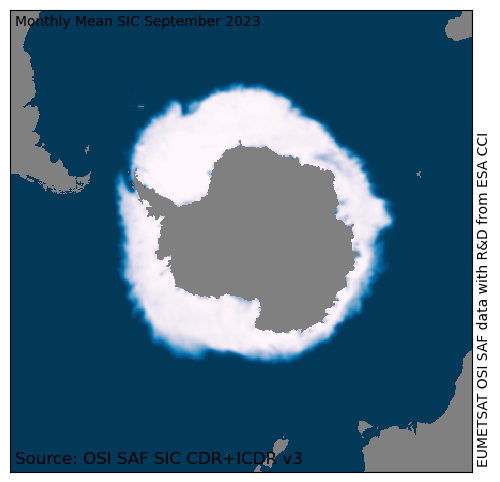

In [22]:
from matplotlib import pylab as plt
from cmocean import cm

cmap = copy(plt.colormaps['PuBu_r'])
cmap.set_bad('grey')

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(month_ds['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=0, vmax=100, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.01,0.99,'Monthly Mean SIC {:%B %Y}'.format(dt,), va='top', transform=ax.transAxes)
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI', rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12, va='bottom', transform=ax.transAxes)
plt.show()

We now need to compute the climatological average SIC for the period we defined earlier.

In [24]:
# compute climatological average
climo_ds = xr.open_mfdataset(climo_fns, engine='netcdf4')
climo_ds = reconstruct_sic(climo_ds)
climo_mean = climo_ds.mean(dim="time", keep_attrs=True)

We can then compute the anomaly between our monthly mean and the climatological average.

In [26]:
# compute climatological anomaly
month_anomaly = month_ds - climo_mean

Let's create a specific folder to hold the anomalies maps we will plot next.

In [28]:
download_dir = os.path.join(os.getcwd(), "anomalies", "mapping")
os.makedirs(download_dir, exist_ok=True)

Let's now plot the anomaly between the monthly mean SIC and the climatological average SIC.

./anomalies/mapping/sea_ice_concentration_anomaly_[plot]_sh_19812010_202309.tiff


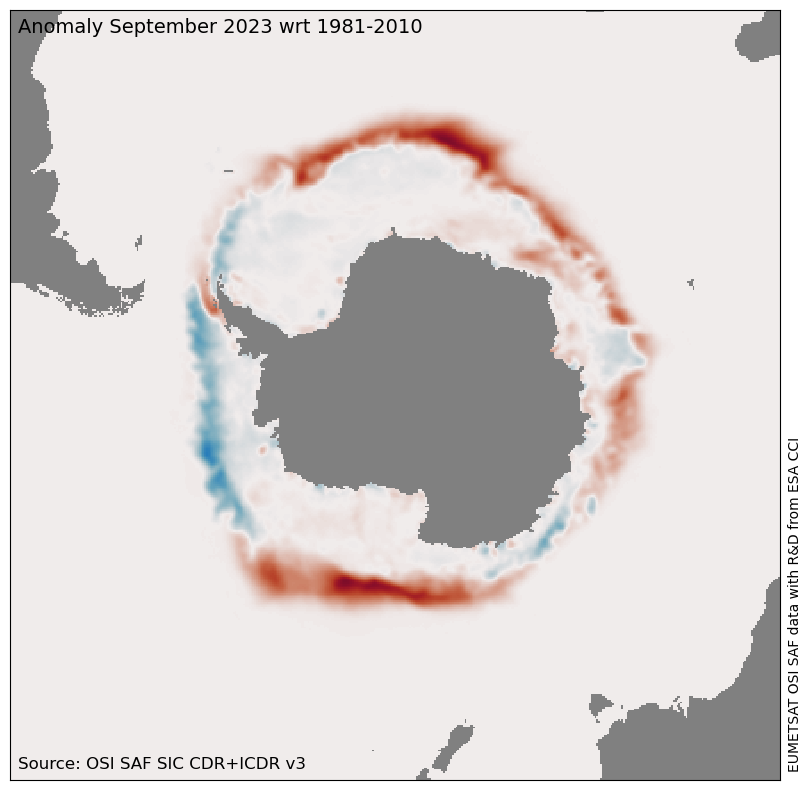

In [30]:
from matplotlib import pylab as plt
from cmocean import cm

cmap = copy(cm.balance_r)
cmap.set_bad('grey')

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(month_anomaly['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=-100, vmax=+100, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.01,0.99,'Anomaly {:%B %Y} wrt {}-{}'.format(dt, *climo), va='top', transform=ax.transAxes, fontsize=14)
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI', rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12, va='bottom', transform=ax.transAxes)


outname = './anomalies/mapping/sea_ice_concentration_anomaly_[plot]_{}_{}{}_{:%Y%m}.tiff'.format(area, climo[0], climo[1], dt)
plt.savefig(outname, bbox_inches='tight')
print(outname)

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Plot the monthly mean SIC and the outline of the climatology median edge.
[Back to top](#TOC-TOP)

</div>

Another way to visualise this anomaly is to compare the monthly mean SIC with the climatological average sea ice edge. We will then use the same computed data to plot another SIC anomaly map including the climatological average edge.

In [32]:
climo_med = climo_ds.median(dim="time", keep_attrs=True)

./anomalies/mapping/sea_ice_concentration_mean_vs_Median_Edge_sh_19812010_202309.tiff


/opt/anaconda3/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


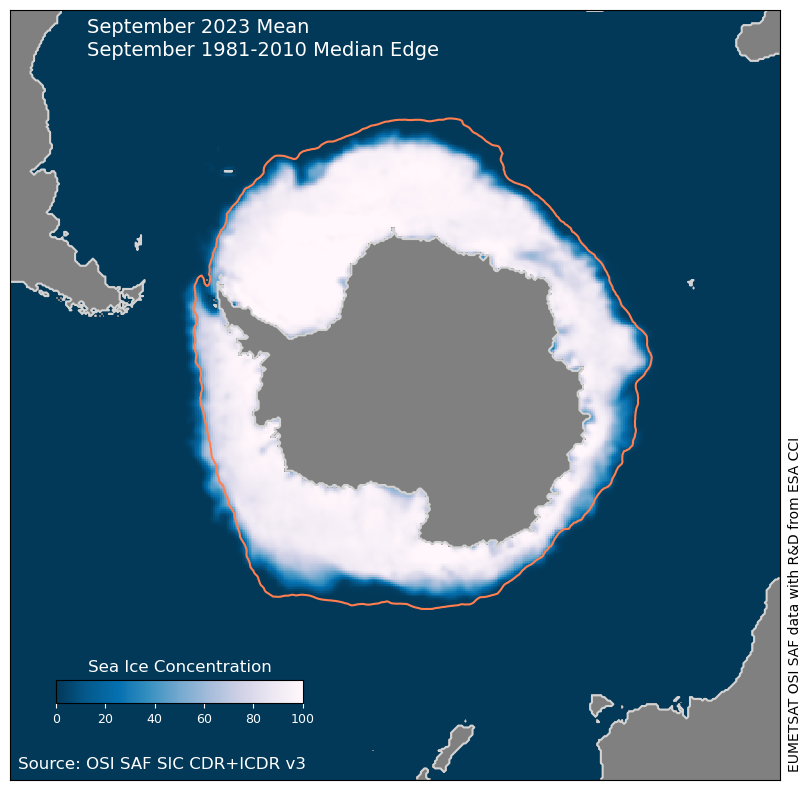

In [33]:
import numpy as np
from matplotlib import pylab as plt
from cmocean import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cmap = copy(cm.ice)
cmap = copy(plt.colormaps['PuBu_r'])
#cmap = copy(plt.colormaps['Blues_r'])
cmap.set_bad('grey')

with_median = True

fig, ax = plt.subplots(figsize=(10,10))
cols = ax.imshow(month_ds['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=0, vmax=100, cmap=cmap)
ax.contour(np.nan_to_num(month_ds['ice_conc'][0].values,nan=-10), levels=(-10.,),
           colors='lightgrey', linestyles='-')
if with_median:
    ax.contour(climo_med['ice_conc'], levels=(15.,), colors='coral',)

cbaxes = inset_axes(ax, width="32%", height="3%", loc=3, borderpad=0,
                    bbox_to_anchor=(0.06, 0.1, 1, 1),
                    bbox_transform=ax.transAxes)
cbar = plt.colorbar(cols, cax=cbaxes, orientation="horizontal",)
cbar.ax.set_title('Sea Ice Concentration',fontsize=12,color='w')
cbar.ax.tick_params(labelsize=9,colors='w')

ax.set_xticks([])
ax.set_yticks([])
ax.text(0.1,0.99,'{d:%B %Y} Mean'.format(d=dt),
        va='top', transform=ax.transAxes, color='w', fontsize=14,)
if with_median:
    ax.text(0.1,0.96,'{d:%B} {c1:}-{c2:} Median Edge'.format(d=dt, c1=climo[0], c2=climo[1]),
        va='top', transform=ax.transAxes, color='w', fontsize=14,)
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI',
        rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12,
        va='bottom', transform=ax.transAxes, color='w',)

outname = './anomalies/mapping/sea_ice_concentration_mean_vs_Median_Edge_{}_{}{}_{:%Y%m}.tiff'.format(area, climo[0], climo[1], dt)
plt.savefig(outname, bbox_inches='tight')
print(outname)

plt.show()

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Save the computed data into a netCDF.
[Back to top](#TOC-TOP)

</div>

Using Thredds doesn't allow us to keep a track of the computing work we have done. If we want to keep a track, or want to work locally on our computer, we can save computing done in the Xarray datasets as a netCDF file, using the to_netcdf() method. <br>
Prodedure to use the sea ice products from a netCDF file is extensively described in our <a href="../1_OSI_SAF_sea_ice_introductory/1_1a_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">introductory notebooks</a>.<br><br>
To note : To be publishable, this netCDF file would require additional metadata, global attributes, and modification should be done on the file format. We have omitted them here to maintain clarity.

Let's start by creating a specific folder to hold the files we will create.

In [36]:
download_dir = os.path.join(os.getcwd(), "anomalies", "data")
os.makedirs(download_dir, exist_ok=True)

We can first start by vizualising the data we are about to compile in a netCDF file. One simple and common way is to use the print function.

In [38]:
print(month_anomaly)

<xarray.Dataset> Size: 5MB
Dimensions:                 (time: 1, xc: 432, yc: 432)
Coordinates:
  * time                    (time) datetime64[ns] 8B 2023-09-16T12:00:00
  * xc                      (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 746kB -16.62 -16.82 ... -16.62
    lon                     (yc, xc) float32 746kB -45.0 -44.87 ... 135.1 135.0
Data variables:
    Lambert_Azimuthal_Grid  float64 8B 0.0
    ice_conc                (time, yc, xc) float64 1MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    raw_ice_conc_values     (time, yc, xc) float64 1MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    status_flag             (time, yc, xc) float32 746kB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>


As we are here using Xarray in a notebook environnement, we can as well simply call for the file. Xarray will display the file content in an interactive way. It gives us the possibility to explore the data.

In [40]:
month_anomaly

<xarray.Dataset> Size: 5MB
Dimensions:                 (time: 1, xc: 432, yc: 432)
Coordinates:
  * time                    (time) datetime64[ns] 8B 2023-09-16T12:00:00
  * xc                      (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 746kB -16.62 -16.82 ... -16.62
    lon                     (yc, xc) float32 746kB -45.0 -44.87 ... 135.1 135.0
Data variables:
    Lambert_Azimuthal_Grid  float64 8B 0.0
    ice_conc                (time, yc, xc) float64 1MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    raw_ice_conc_values     (time, yc, xc) float64 1MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    status_flag             (time, yc, xc) float32 746kB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

Let's now save the data into a netCDF. We start by defining the name, and then we will write it.

In [42]:
outname = './anomalies/data/sea_ice_concentration_anomaly_{}_{}{}_{:%Y%m}.nc'.format(area, climo[0], climo[1], dt)

In [43]:
# write to netCDF/CF
month_anomaly.to_netcdf(outname)

print(outname, "is ready.")

./anomalies/data/sea_ice_concentration_anomaly_sh_19812010_202309.nc is ready.


<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_1a_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank"><< OSI SAF sea ice introductory</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./2_2_OSI_SAF_sea_ice_plot_anomaly_as_a_spiral.ipynb" target="_blank">Plot OSI SAF sea ice data as a spiral >> </a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>